In [10]:
from atproto import Client
import spacy
from urlextract import URLExtract
import pandas as pd
import demoji
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

url_extractor = URLExtract()
nlp = spacy.load("en_core_web_sm")

plt.style.use('ggplot')

In [2]:
HANDLE = 'asinvader.bsky.social'
KEY = os.getenv('BSKEY')

In [ ]:
from atproto import Client

# Initialize the client
client = Client()

# Log in with your handle and password
client.login(HANDLE, KEY)



In [4]:
# Retrieve your profile information
profile = client.get_profile(client.me.did)

# Access and print the number of followers
follower_count = profile.followers_count
print(f'You have {follower_count} followers.')

You have 17 followers.


In [5]:
my_did = client.me.did

# Fetch the list of followers
#response = client.app.bsky.graph.get_followers({'actor': my_did})
response = client.get_follows(actor = HANDLE)
followers = response['follows']

In [6]:
BASE_CLEAN_TEXT_RESPONSE = {'text':None,'clean_text':None,'url':None}
URL_PLACEHOLDER = '[URL]'
EMOJI_PLACEHOLDER = '[E]'


def clean_text(text, spacy_nlp, url_extractor):

    if not text:
        return BASE_CLEAN_TEXT_RESPONSE
    
    text = text.replace('\n',' ')
    urls = url_extractor.find_urls(text)
    emojis = demoji.findall(text)

    doc = None
    
    if len(urls):
        for url in urls:
            #doc = text.replace(url, ' ')
            text = text.replace(url, URL_PLACEHOLDER)
            
    if len(emojis):
        for emoji in emojis:
            #doc = text.replace(emoji, ' ')
            text = text.replace(emoji, EMOJI_PLACEHOLDER)
            

    doc = text.replace(URL_PLACEHOLDER, ' ')
    doc = doc.replace(EMOJI_PLACEHOLDER, ' ')
    doc = spacy_nlp(doc)
    
    filtered_tokens = [token.text for token in doc if not token.is_stop or token.text not in ['\'m']]

    reconstructed_string = ' '.join(filtered_tokens)

    return {
        'text':text,
        'clean_text':reconstructed_string,
        'url':urls,
        'emojis':emojis
    }

In [7]:
def compile_descriptions(raw_data, nlp, url_extractor):
    descriptions = []
    for datum in raw_data:
        descriptions.append(clean_text(datum.description, nlp, url_extractor))

    return pd.DataFrame(descriptions)


def get_all_follows(client, user_id):

    raw_data = client.get_follows(actor = user_id)
    cursor = raw_data['cursor']
    follows = raw_data['follows']

    while cursor:
        raw_data = client.get_follows(actor = user_id, cursor = cursor)
        follows += raw_data['follows']
        cursor = raw_data['cursor']
        

    return follows

In [8]:
follows = compile_descriptions(get_all_follows(client, HANDLE), nlp, url_extractor)

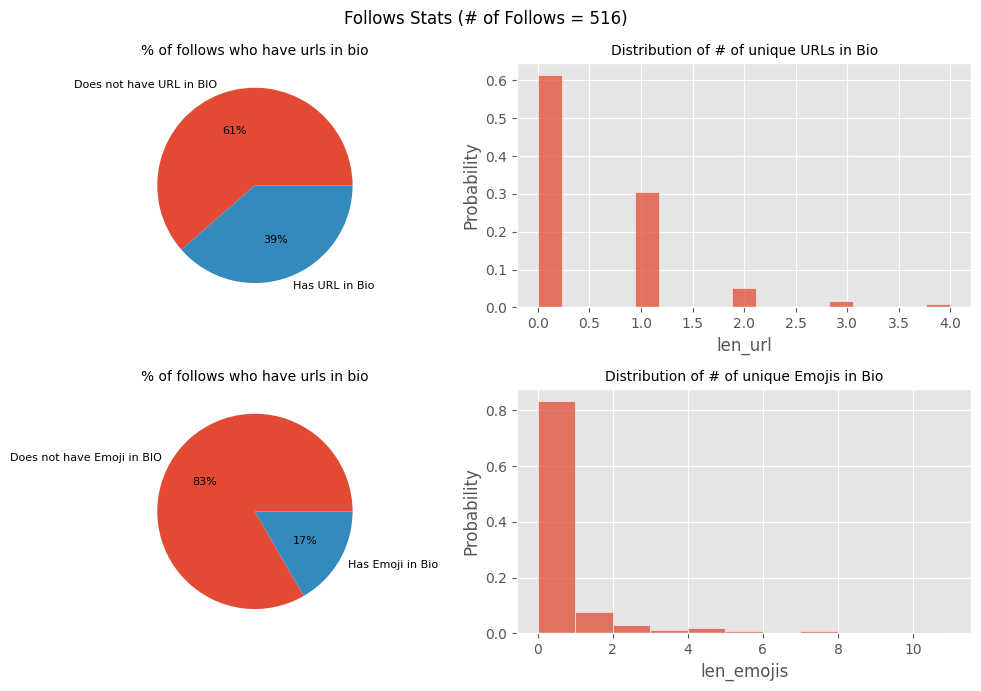

In [11]:
follows['len_url'] = follows['url'].apply(lambda x: len(set(x)) if type(x) == list else 0)
follows['len_emojis'] = follows['emojis'].apply(lambda x: len(set(x)) if type(x) == dict else 0)


fig = plt.figure(figsize  = (10,7))

ax1 = fig.add_subplot(2,2,1)
tmp = follows['len_url'].apply(lambda x: 'Has URL in Bio' if bool(x) else 'Does not have URL in BIO').value_counts() * 100 / follows.shape[0]
ax1.pie(tmp, labels = tmp.index.tolist(), autopct='%.0f%%', textprops={'fontsize': 8})
ax1.set_title("% of follows who have urls in bio", fontsize = 10)

ax2 = fig.add_subplot(2,2,2)
sns.histplot(data = follows, x = 'len_url', stat = 'probability', ax = ax2)
ax2.set_title('Distribution of # of unique URLs in Bio', fontsize = 10)
plt.tight_layout()

ax3 = fig.add_subplot(2,2,3)
tmp = follows['len_emojis'].apply(lambda x: 'Has Emoji in Bio' if bool(x) else 'Does not have Emoji in BIO').value_counts() * 100 / follows.shape[0]
ax3.pie(tmp, labels = tmp.index.tolist(), autopct='%.0f%%', textprops={'fontsize': 8})
ax3.set_title("% of follows who have urls in bio", fontsize = 10)

ax4 = fig.add_subplot(2,2,4)
sns.histplot(data = follows, x = 'len_emojis', stat = 'probability', ax = ax4)
ax4.set_title('Distribution of # of unique Emojis in Bio', fontsize = 10)

fig.suptitle(f'Follows Stats (# of Follows = {follows.shape[0]:.0f})')
plt.tight_layout()
plt.show()
